# Overview

Objective: Determine what drives success (as defined by visits, which is assumed to be revenue) in DC.

Yelp (visits, reviews, positivity), Instagram/FB (brand awareness), news coverage

## Yelp Insights

We seek to know what visitors at restaurants have to say about well-performing wine bars. What causes a positive experience? Who is visiting? What drives out-of-town visits? In-town visits? How are restaurant reviews trending over time? Do repeat customers exist? Where do Yelp wine bar connoseurs go? (How can we attract the right ones?)

![chart](https://data.world/api/chart/export/8b8dc69a0da693c4a134dd80d49c4851cf1b37a81753825815ae70e8b974038d.png)

tl;dr: Barcelona is killing it

In [63]:
# import libraries
import pandas as pd
% matplotlib inline

In [3]:
wine = pd.read_csv('https://query.data.world/s/A2CYWTYyqnma6Y7iFOOKXDuKwZreZz')

In [4]:
wine.head()

,rest_name,username,review,stars,date,location
0,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,This review is massively overdue (I don't writ...,5,8/25/2017,"Washington, DC"
1,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,My friends and I were looking for a good happy...,4,9/25/2017,"Washington, DC"
2,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,Elegant and intimate - La Jambe has an unexpec...,4,8/11/2017,"Washington, DC"
3,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ"
4,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,Hooray for happy hour! $5 for delicious wines?...,4,7/10/2017,"Washington, DC"


# Repeat users analysis

In [12]:
wine.shape

(4934, 6)

In [14]:
# what percent of reviews are by repeat users?
(1 - float(wine.username.nunique()) / wine.shape[0])*100

16.396432914471013

In [16]:
# how many restaraunts
wine.rest_name.nunique()

19

In [32]:
# get repeat people
repeats = wine.username.duplicated()

In [33]:
repeats

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
4904    False
4905     True
4906     True
4907    False
4908    False
4909    False
4910    False
4911     True
4912    False
4913    False
4914     True
4915    False
4916    False
4917     True
4918     True
4919    False
4920    False
4921    False
4922     True
4923    False
4924    False
4925    False
4926    False
4927    False
4928    False
4929    False
4930    False
4931    False
4932    False
4933     True
Name: username, dtype: bool

In [35]:
# get reviews from unique people
wine[repeats]

,rest_name,username,review,stars,date,location
68,La Jambe,/user_details?userid=-9YZc25iHMluMxf949822Q,This place is a delight. Wonderful charcuterie...,5,6/30/2016,"Washington, DC"
108,ENO Wine Bar,/user_details?userid=UrkD6iinGp26KvsWi8c7pQ,The flights of wine are a unique idea and they...,3,1/15/2014,"Arlington, VA"
127,ENO Wine Bar,/user_details?userid=UrkD6iinGp26KvsWi8c7pQ,Honestly one of the best places I've been to i...,5,11/18/2013,"Alameda, CA"
140,Bin 1301 Wine Bar,/user_details?userid=KiyPUvmz2HDmZvP8yiiuxw,We came here on a rainy day that also happened...,4,5/9/2017,"Washington, DC"
189,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,My friends and I were looking for a good happy...,4,9/25/2017,"Washington, DC"
190,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,Elegant and intimate - La Jambe has an unexpec...,4,8/11/2017,"Washington, DC"
191,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ"
192,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,Hooray for happy hour! $5 for delicious wines?...,4,7/10/2017,"Washington, DC"
193,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,$5 happy hour wines at the corner gem La Jambe...,4,6/5/2017,"Washington, DC"
194,La Jambe,/user_details?userid=B1U0NiIcCltvuBXd8NbtuQ,This little gem is a fantastic place for happy...,5,6/23/2017,"Berkeley, CA"


In [36]:
# do the above in one line
wine[wine.username.duplicated()]

,rest_name,username,review,stars,date,location
68,La Jambe,/user_details?userid=-9YZc25iHMluMxf949822Q,This place is a delight. Wonderful charcuterie...,5,6/30/2016,"Washington, DC"
108,ENO Wine Bar,/user_details?userid=UrkD6iinGp26KvsWi8c7pQ,The flights of wine are a unique idea and they...,3,1/15/2014,"Arlington, VA"
127,ENO Wine Bar,/user_details?userid=UrkD6iinGp26KvsWi8c7pQ,Honestly one of the best places I've been to i...,5,11/18/2013,"Alameda, CA"
140,Bin 1301 Wine Bar,/user_details?userid=KiyPUvmz2HDmZvP8yiiuxw,We came here on a rainy day that also happened...,4,5/9/2017,"Washington, DC"
189,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,My friends and I were looking for a good happy...,4,9/25/2017,"Washington, DC"
190,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,Elegant and intimate - La Jambe has an unexpec...,4,8/11/2017,"Washington, DC"
191,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ"
192,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,Hooray for happy hour! $5 for delicious wines?...,4,7/10/2017,"Washington, DC"
193,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,$5 happy hour wines at the corner gem La Jambe...,4,6/5/2017,"Washington, DC"
194,La Jambe,/user_details?userid=B1U0NiIcCltvuBXd8NbtuQ,This little gem is a fantastic place for happy...,5,6/23/2017,"Berkeley, CA"


In [40]:
wine[wine.username.duplicated()].shape

(809, 6)

In [56]:
wine[wine.username.duplicated()].stars.mean()

3.776266996291718

In [57]:
wine.stars.mean()

3.8603567085528985

In [58]:
wine['repeat'] = wine.username.duplicated()

In [59]:
wine[wine.repeat == False].stars.mean()

3.8768484848484848

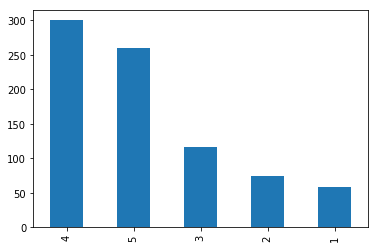

In [71]:
wine[wine.repeat == True].stars.value_counts().plot(kind='bar')

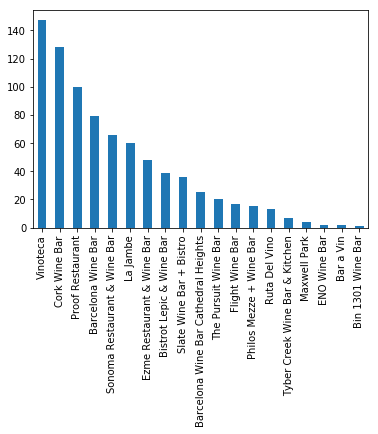

In [73]:
wine[wine.repeat == True].rest_name.value_counts().plot(kind='bar')

### A/B test : Do repeat users have statistically signficant lower ratings?

# Out of town vs in town

In [76]:
wine.location.value_counts()

Washington, DC                       1885
Arlington, VA                         297
Alexandria, VA                        159
New York, NY                          116
San Francisco, CA                      98
Silver Spring, MD                      89
Fairfax, VA                            73
Bethesda, MD                           61
Baltimore, MD                          60
Chicago, IL                            58
Los Angeles, CA                        55
Washington D.C., DC                    54
Falls Church, VA                       51
Rockville, MD                          46
Brooklyn, NY                           45
Manhattan, NY                          45
San Diego, CA                          36
Seattle, WA                            31
Philadelphia, PA                       29
Vienna, VA                             26
McLean, VA                             24
Boston, MA                             24
Portland, OR                           22
Austin, TX                        

In [95]:
# define inside / outside beltway
DMV = (wine.location == "Washington, DC") | (wine.location == "Arlington, VA") | (wine.location == "Alexandria, VA") | (wine.location == "Silver Spring, MD") | (wine.location == "Washington D.C., DC") | (wine.location == "Fairfax, VA") | (wine.location == "Falls Church, VA") | (wine.location == "Bethesda, MD")


In [97]:
wine[DMV].shape

(2669, 8)

In [100]:
# what percent is in the DMV?
float(wine[DMV].shape[0]) / wine.shape[0]*100

54.09404134576409

In [101]:
wine['dmv'] = DMV

In [108]:
wine[wine.dmv == True].stars.mean()

3.8220307231172725

In [109]:
wine[wine.dmv == False].stars.mean()

3.9055187637969095

In [116]:
wine[wine.dmv == True].rest_name.value_counts()/wine.shape[0]

Barcelona Wine Bar                      0.117754
Proof Restaurant                        0.078435
Vinoteca                                0.078233
Cork Wine Bar                           0.049453
Sonoma Restaurant & Wine Bar            0.039522
Ezme Restaurant & Wine Bar              0.024524
Flight Wine Bar                         0.020876
Barcelona Wine Bar Cathedral Heights    0.020065
Bistrot Lepic & Wine Bar                0.020065
La Jambe                                0.019660
Slate Wine Bar + Bistro                 0.017430
The Pursuit Wine Bar                    0.015403
Ruta Del Vino                           0.010134
Philos Mezze + Wine Bar                 0.006891
Tyber Creek Wine Bar & Kitchen          0.006486
ENO Wine Bar                            0.005675
Bin 1301 Wine Bar                       0.005270
Bar a Vin                               0.002635
Maxwell Park                            0.002432
Name: rest_name, dtype: float64

In [117]:
wine[wine.dmv == False].rest_name.value_counts()/wine.shape[0]

Barcelona Wine Bar                      0.101135
Proof Restaurant                        0.091812
Vinoteca                                0.055533
Sonoma Restaurant & Wine Bar            0.037495
Ezme Restaurant & Wine Bar              0.036279
Cork Wine Bar                           0.035671
Flight Wine Bar                         0.017633
Bistrot Lepic & Wine Bar                0.016417
Slate Wine Bar + Bistro                 0.013174
Barcelona Wine Bar Cathedral Heights    0.012363
The Pursuit Wine Bar                    0.008918
Bin 1301 Wine Bar                       0.006891
La Jambe                                0.006486
ENO Wine Bar                            0.006283
Philos Mezze + Wine Bar                 0.005270
Ruta Del Vino                           0.003243
Tyber Creek Wine Bar & Kitchen          0.001621
Maxwell Park                            0.001419
Bar a Vin                               0.001419
Name: rest_name, dtype: float64

In [124]:
wine[wine.dmv == False].rest_name.value_counts()/wine.shape[0] - wine[wine.dmv == True].rest_name.value_counts()/wine.shape[0]

Bar a Vin                              -0.001216
Barcelona Wine Bar                     -0.016619
Barcelona Wine Bar Cathedral Heights   -0.007702
Bin 1301 Wine Bar                       0.001621
Bistrot Lepic & Wine Bar               -0.003648
Cork Wine Bar                          -0.013782
ENO Wine Bar                            0.000608
Ezme Restaurant & Wine Bar              0.011755
Flight Wine Bar                        -0.003243
La Jambe                               -0.013174
Maxwell Park                           -0.001013
Philos Mezze + Wine Bar                -0.001621
Proof Restaurant                        0.013377
Ruta Del Vino                          -0.006891
Slate Wine Bar + Bistro                -0.004256
Sonoma Restaurant & Wine Bar           -0.002027
The Pursuit Wine Bar                   -0.006486
Tyber Creek Wine Bar & Kitchen         -0.004864
Vinoteca                               -0.022700
Name: rest_name, dtype: float64

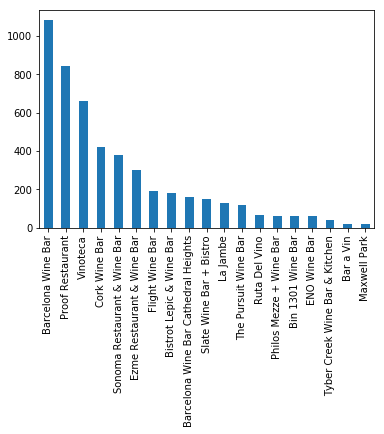

In [121]:
wine.rest_name.value_counts().plot(kind='bar')

### A/B Test: Are out of towners nicer than those in the DMV?

# Restaurant trends over time